In [1]:
import numpy as np
import pickle

# Téléchargement et extraction des données
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from scipy.spatial.distance import hamming ,cosine ,euclidean
from tqdm import tqdm
import pickle
import cv2
import os
import tarfile
from keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam, SGD
from keras import Sequential,datasets

In [2]:
url = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
filename = 'cifar-10-python.tar.gz'
urllib.request.urlretrieve(url, filename)

('cifar-10-python.tar.gz', <http.client.HTTPMessage at 0x7f8776b9cfa0>)

In [3]:
# Extraction des données du fichier tar.gz
with tarfile.open(filename, 'r:gz') as tar:
    tar.extractall()

In [5]:
# Chargement des données depuis les fichiers pickle
train_batches = []
for i in range(1, 6):
    with open(f'cifar-10-batches-py/data_batch_{i}', 'rb') as file:
        train_batches.append(pickle.load(file, encoding='bytes'))

test_batch = None
with open('cifar-10-batches-py/test_batch', 'rb') as file:
    test_batch = pickle.load(file, encoding='bytes')

In [6]:
# Prétraitement des données
X_train = np.vstack([batch[b"data"] for batch in train_batches])
X_test = test_batch[b"data"]
y_train = np.hstack([batch[b"labels"] for batch in train_batches])
y_test = np.array(test_batch[b"labels"])

In [7]:
X_train = X_train.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
X_test = X_test.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

In [8]:
# Normalisation des pixels entre 0 et 1
X_train = X_train / 255.0
X_test = X_test / 255.0

In [9]:
# One-hot encoding des étiquettes
y_train_onehot = np.zeros((y_train.shape[0], 10))
y_train_onehot[np.arange(y_train.shape[0]), y_train] = 1

y_test_onehot = np.zeros((y_test.shape[0], 10))
y_test_onehot[np.arange(y_test.shape[0]), y_test] = 1

In [10]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rotation_range=20, # rotation aléatoire entre 0 et 20 degrés
        width_shift_range=0.2, # décalage horizontal aléatoire
        height_shift_range=0.2, # décalage vertical aléatoire
        horizontal_flip=True, # renversement horizontal aléatoire
        fill_mode='nearest') # remplissage des pixels manquants avec les pixels voisins

# appliquer l'augmentation de données aux images d'entraînement
datagen.fit(X_train)

In [11]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                        

In [13]:
# Entraînement du modèle
history = model.fit(X_train, y_train_onehot, epochs=10, batch_size=64, validation_data=(X_test, y_test_onehot))

Epoch 1/10
782/782 [==============================] - 829s 1s/step - loss: 1.8964 - accuracy: 0.3458 - val_loss: 1.3135 - val_accuracy: 0.5199
Epoch 2/10
782/782 [==============================] - 829s 1s/step - loss: 1.2736 - accuracy: 0.5457 - val_loss: 1.2330 - val_accuracy: 0.5833
Epoch 3/10
782/782 [==============================] - 827s 1s/step - loss: 1.0230 - accuracy: 0.6459 - val_loss: 0.9014 - val_accuracy: 0.6840
Epoch 4/10
782/782 [==============================] - 825s 1s/step - loss: 0.8886 - accuracy: 0.6982 - val_loss: 0.7606 - val_accuracy: 0.7411
Epoch 5/10
782/782 [==============================] - 842s 1s/step - loss: 0.7971 - accuracy: 0.7347 - val_loss: 0.6566 - val_accuracy: 0.7791
Epoch 6/10
782/782 [==============================] - 784s 1s/step - loss: 0.7220 - accuracy: 0.7607 - val_loss: 0.7158 - val_accuracy: 0.7600
Epoch 7/10
782/782 [==============================] - 806s 1s/step - loss: 0.6645 - accuracy: 0.7810 - val_loss: 0.6953 - val_accuracy: 0.7698

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                        

313/313 [==============================] - 44s 140ms/step


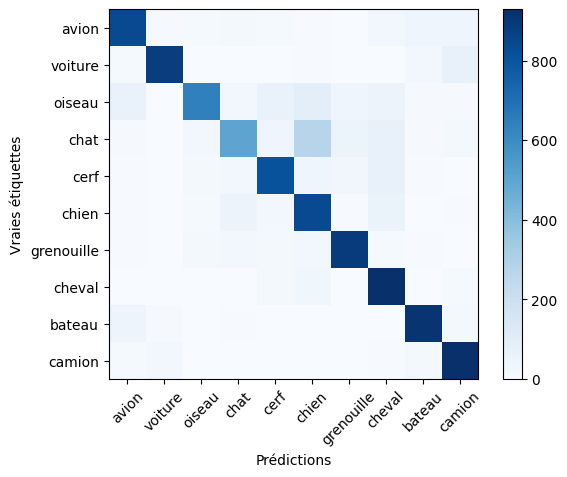

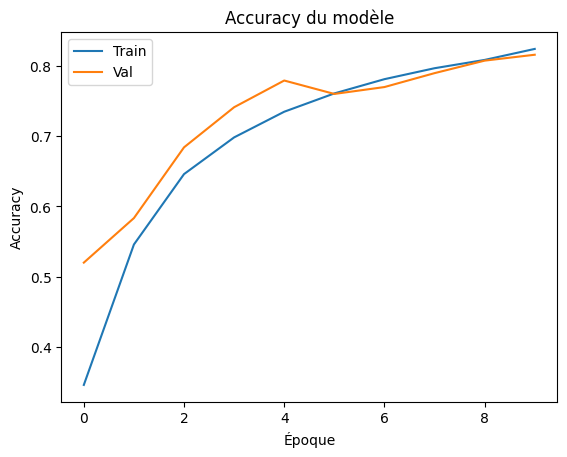

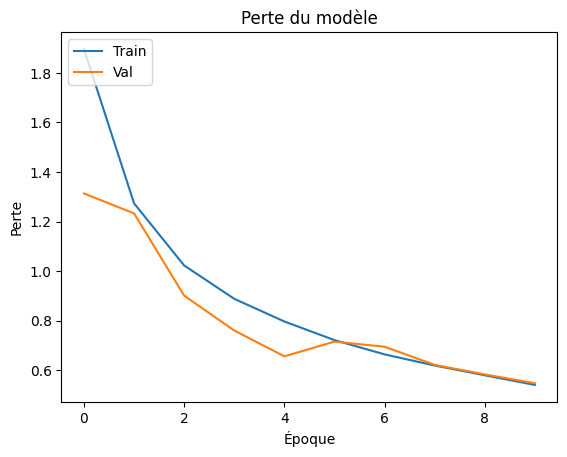

              precision    recall  f1-score   support

       avion       0.84      0.83      0.84      1000
     voiture       0.94      0.88      0.91      1000
      oiseau       0.87      0.64      0.74      1000
        chat       0.76      0.50      0.61      1000
        cerf       0.82      0.81      0.82      1000
       chien       0.64      0.83      0.72      1000
  grenouille       0.86      0.89      0.87      1000
      cheval       0.76      0.93      0.84      1000
      bateau       0.89      0.91      0.90      1000
      camion       0.85      0.93      0.89      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.81     10000
weighted avg       0.82      0.82      0.81     10000

Accuracy globale :  0.8158


In [15]:
from sklearn.metrics import confusion_matrix ,classification_report
from sklearn.metrics import accuracy_score


y_pred = model.predict(X_test)

# Convertir les prédictions en classes
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculer la matrice de confusion
confusion_mtx = confusion_matrix(y_test, y_pred_classes)

# Afficher la matrice de confusion
plt.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(10)
label_names = ['avion', 'voiture', 'oiseau', 'chat', 'cerf', 'chien', 'grenouille', 'cheval', 'bateau', 'camion']
plt.xticks(tick_marks, label_names, rotation=45)
plt.yticks(tick_marks, label_names)
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.show()

# Afficher les courbes de l'accuracy et de la perte au fil des époques
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy du modèle')
plt.ylabel('Accuracy')
plt.xlabel('Époque')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perte du modèle')
plt.ylabel('Perte')
plt.xlabel('Époque')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Afficher le rapport de classification
print(classification_report(y_test, y_pred_classes, target_names=label_names))

# Calculer l'accuracy globale
accuracy = accuracy_score(y_test, y_pred_classes)
print('Accuracy globale : ', accuracy)

In [17]:
model.save('deep2.h5')